In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

import scipy.spatial
from itertools import combinations
from scipy.spatial.distance import pdist
from scipy import optimize

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [8]:
plt.style.use('ggplot')

In [2]:
locations = pd.read_csv('Data\stations.txt', sep=' ', index_col=0)

locations.head(20)

,database,station_latitude(dec.degree),station_longitude(dec.degree),station_altitude(m)
station_name,,,,
TILLABERI,AMMA-CATCH,14.204300,1.454500,212.0
TOBRE,AMMA-CATCH,10.199100,2.133500,371.0
TARA,AMMA-CATCH,15.251400,-1.585500,335.0
AGOUFOU,AMMA-CATCH,15.360000,-1.470000,340.0
LAWRA,MARLOES,10.866670,-1.483330,305.0
NAVRONGO,MARLOES,10.530000,-1.050000,201.3
OUAHIGOUYA,MARLOES,13.520000,-2.390000,365.0
TAMALE,MARLOES,9.330000,-0.510000,183.3
WA,MARLOES,10.030000,-2.090000,322.7


## Next, we are going to merge the 1-pixel satelite products with the gauge measurements only at the dates that both values are measured: TRAINING DATA

In [3]:
# load the .csv 

TILLABERIsat9 = pd.read_csv("OrganisedData\MSWEP\TILLABERIsat9.csv", index_col=0)
TOBREsat9 = pd.read_csv("OrganisedData\MSWEP\TOBREsat9.csv", index_col=0)
TARAsat9 = pd.read_csv("OrganisedData\MSWEP\TARAsat9.csv", index_col=0)
AGOUFOUsat9 = pd.read_csv("OrganisedData\MSWEP\AGOUFOUsat9.csv", index_col=0)
LAWRAsat9 = pd.read_csv("OrganisedData\MSWEP\LAWRAsat9.csv", index_col=0)
NAVRONGOsat9 = pd.read_csv("OrganisedData\MSWEP\\NAVRONGOsat9.csv", index_col=0)
OUAHIGOUYAsat9 = pd.read_csv("OrganisedData\MSWEP\OUAHIGOUYAsat9.csv", index_col=0)
TAMALEsat9 = pd.read_csv("OrganisedData\MSWEP\TAMALEsat9.csv", index_col=0)
WAsat9 = pd.read_csv("OrganisedData\MSWEP\WAsat9.csv", index_col=0)
ZUARUNGUsat9 = pd.read_csv("OrganisedData\MSWEP\ZUARUNGUsat9.csv", index_col=0)
ANIABISIsat9 = pd.read_csv("OrganisedData\MSWEP\ANIABISIsat9.csv", index_col=0)
POUDRIsat9 = pd.read_csv("OrganisedData\MSWEP\POUDRIsat9.csv", index_col=0)
LAREsat9 = pd.read_csv("OrganisedData\MSWEP\LAREsat9.csv", index_col=0)
YABOGANEsat9 = pd.read_csv("OrganisedData\MSWEP\YABOGANEsat9.csv", index_col=0)

# ZUARUNGUsat9.head(10000)

## Loading the gauge measurements, one has to make sure that: (a) the dates have no time (even discarded manually) and (b) the values have been loaded.

In [4]:
# load the time-series 

TILLABERI = pd.read_csv("OrganisedData\Gauges\stationTILLABERI.csv", index_col=0)
TOBRE = pd.read_csv("OrganisedData\Gauges\stationTOBRE.csv", index_col=0)
TARA = pd.read_csv("OrganisedData\Gauges\stationTARA.csv", index_col=0)
AGOUFOU = pd.read_csv("OrganisedData\Gauges\stationAGOUFOU.csv", index_col=0)
LAWRA = pd.read_csv("OrganisedData\Gauges\stationLAWRA.csv", index_col=0)
NAVRONGO = pd.read_csv("OrganisedData\Gauges\\stationNAVRONGO.csv", index_col=0)
OUAHIGOUYA = pd.read_csv("OrganisedData\Gauges\stationOUAHIGOUYA.csv", index_col=0)
TAMALE = pd.read_csv("OrganisedData\Gauges\stationTAMALE.csv", index_col=0)
WA = pd.read_csv("OrganisedData\Gauges\stationWA.csv", index_col=0)
ZUARUNGU = pd.read_csv("OrganisedData\Gauges\stationZUARUNGU.csv", index_col=0)
ANIABISI = pd.read_csv("OrganisedData\Gauges\stationANIABISI.csv", index_col=0)
POUDRI = pd.read_csv("OrganisedData\Gauges\stationPOUDRI.csv", index_col=0)
LARE = pd.read_csv("OrganisedData\Gauges\stationLARE.csv", index_col=0)
YABOGANE = pd.read_csv("OrganisedData\Gauges\stationYABOGANE.csv", index_col=0)

# AGOUFOU.head(10000)

# TRAINING DATA

# 1. TILLABERI

In [5]:
TILLABERItrain = TILLABERI.merge(TILLABERIsat9, how='left', left_on=TILLABERI.index, right_on=TILLABERIsat9.index)
TILLABERItrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TILLABERItrain.set_index('Date', inplace=True)

# TILLABERItrain

In [6]:
# correlation estimation

rho = TILLABERItrain['g[mm]'].corr(TILLABERItrain['sat[mm]'])

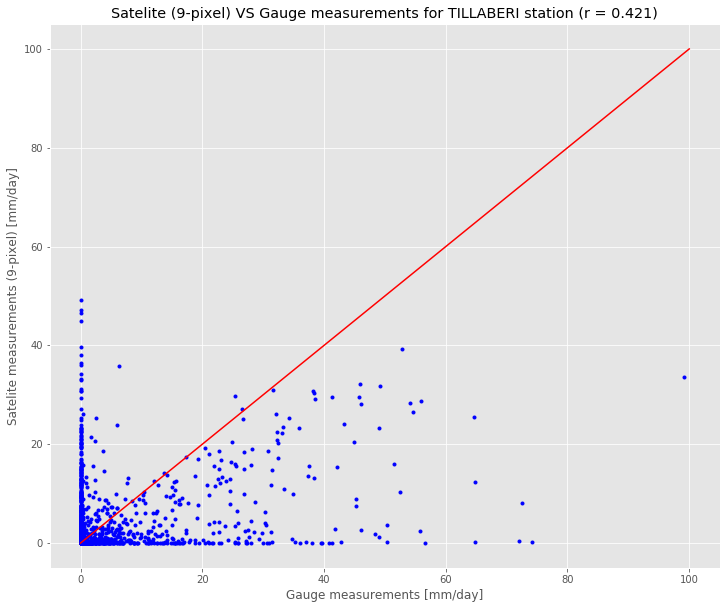

In [9]:
plt.figure(figsize=(12, 10))

plt.plot(TILLABERItrain['g[mm]'], TILLABERItrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9-pixel) VS Gauge measurements for TILLABERI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9-pixel) VS Gauge measurements for TILLABERI station.png');

In [10]:
TILLABERItrain.to_csv("OrganisedData\TrainingData\TILLABERItrain9pixelsMEAN.csv")

# 2. TOBRE

In [11]:
TOBREtrain = TOBRE.merge(TOBREsat9, how='left', left_on=TOBRE.index, right_on=TOBREsat9.index)
TOBREtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TOBREtrain.set_index('Date', inplace=True)

In [12]:
TOBREtrain = TOBREtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

TOBREtrain

,g[mm],sat[mm]
Date,,
1999-01-01,0.0,0.0
1999-01-02,0.0,0.0
1999-01-03,0.0,0.0
1999-01-04,0.0,0.0
1999-01-05,0.0,0.0
...,...,...
2016-12-27,0.0,0.0
2016-12-28,0.0,0.0
2016-12-29,0.0,0.0


In [13]:
# correlation estimation

rho = TOBREtrain['g[mm]'].corr(TOBREtrain['sat[mm]'])

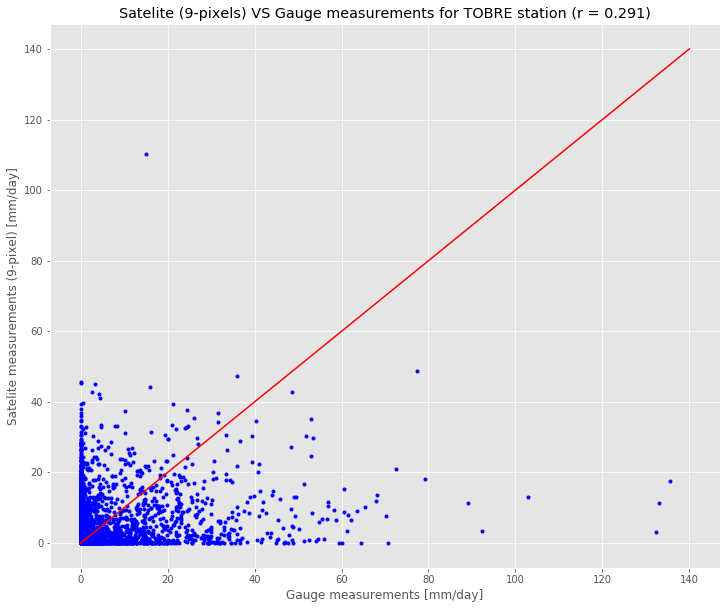

In [14]:
plt.figure(figsize=(12, 10))

plt.plot(TOBREtrain['g[mm]'], TOBREtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 140, 2), np.linspace(0, 140, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9-pixels) VS Gauge measurements for TOBRE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9-pixels) VS Gauge measurements for TOBRE station.png');

In [15]:
TOBREtrain.to_csv("OrganisedData\TrainingData\TOBREtrain9pixelsMEAN.csv")

# 3. TARA

In [16]:
TARAtrain = TARA.merge(TARAsat9, how='left', left_on=TARA.index, right_on=TARAsat9.index)
TARAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TARAtrain.set_index('Date', inplace=True)

TARAtrain = TARAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

TARAtrain.to_csv("OrganisedData\TrainingData\TARAtrain9pixelsMEAN.csv")

TARAtrain

,g[mm],sat[mm]
Date,,
2004-05-01,0.0,0.0
2004-05-02,0.0,0.0
2004-05-03,0.0,0.0
2004-05-04,0.0,0.0
2004-05-05,0.0,0.0
...,...,...
2016-12-27,0.0,0.0
2016-12-28,0.0,0.0
2016-12-29,0.0,0.0


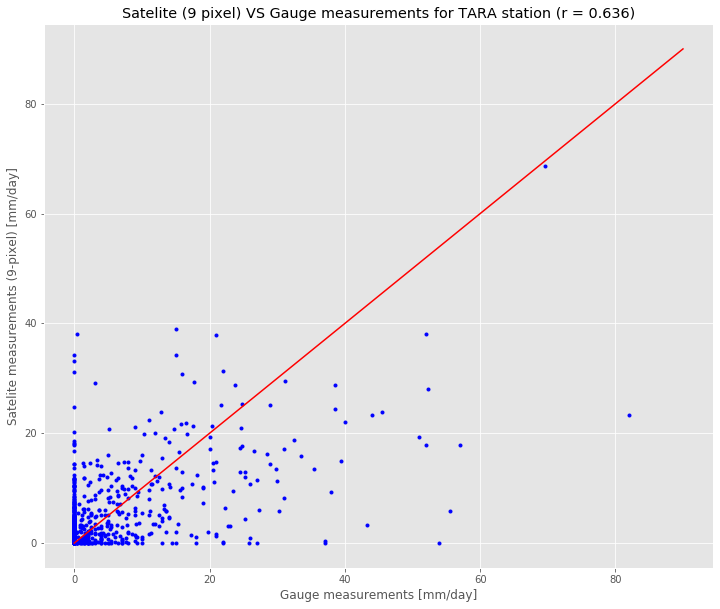

In [17]:
# correlation estimation

rho = TARAtrain['g[mm]'].corr(TARAtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(TARAtrain['g[mm]'], TARAtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for TARA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for TARA station.png');

# 4. AGOUFOU

In [18]:
AGOUFOUtrain = AGOUFOU.merge(AGOUFOUsat9, how='left', left_on=AGOUFOU.index, right_on=AGOUFOUsat9.index)
AGOUFOUtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
AGOUFOUtrain.set_index('Date', inplace=True)

AGOUFOUtrain = AGOUFOUtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

AGOUFOUtrain.to_csv("OrganisedData\TrainingData\AGOUFOUtrain9pixelsMEAN.csv")

AGOUFOUtrain

,g[mm],sat[mm]
Date,,
2003-05-01,0.0,0.0
2003-05-02,0.0,0.0
2003-05-03,0.0,0.0
2003-05-04,0.0,0.0
2003-05-05,0.0,0.0
...,...,...
2016-12-27,0.0,0.0
2016-12-28,0.0,0.0
2016-12-29,0.0,0.0


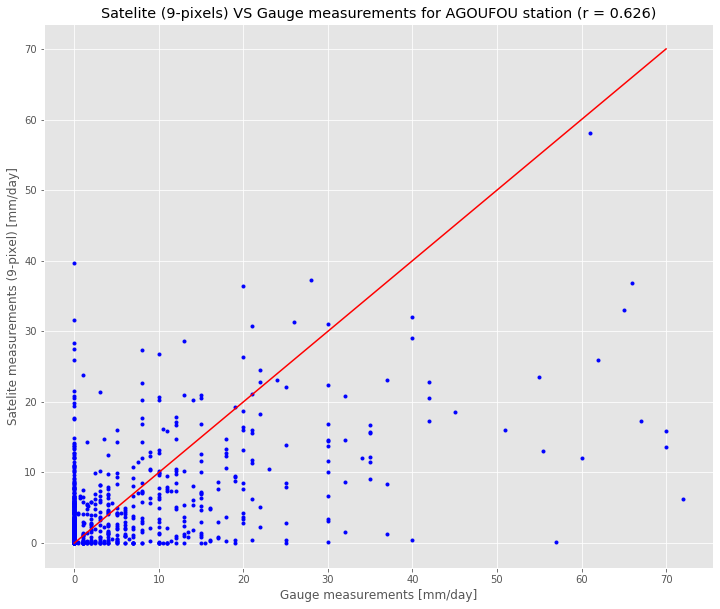

In [19]:
# correlation estimation

rho = AGOUFOUtrain['g[mm]'].corr(AGOUFOUtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(AGOUFOUtrain['g[mm]'], AGOUFOUtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 70, 2), np.linspace(0, 70, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9-pixels) VS Gauge measurements for AGOUFOU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9-pixels) VS Gauge measurements for AGOUFOU station.png');

# 5. LAWRA

In [20]:
LAWRAtrain = LAWRA.merge(LAWRAsat9, how='left', left_on=LAWRA.index, right_on=LAWRAsat9.index)
LAWRAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
LAWRAtrain.set_index('Date', inplace=True)

LAWRAtrain = LAWRAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

LAWRAtrain.to_csv("OrganisedData\TrainingData\LAWRAtrain9pixelsMEAN.csv")

LAWRAtrain

,g[mm],sat[mm]
Date,,
1980-01-01,0.0,0.0
1980-01-02,0.0,0.0
1980-01-03,0.0,0.0
1980-01-04,0.0,0.0
1980-01-05,0.0,0.0
...,...,...
2002-12-27,0.0,0.0
2002-12-28,0.0,0.0
2002-12-29,0.0,0.0


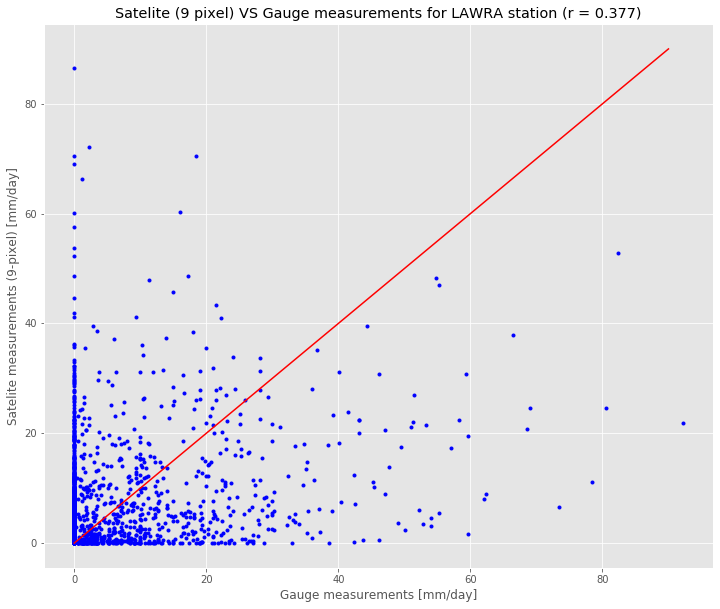

In [21]:
rho = LAWRAtrain['g[mm]'].corr(LAWRAtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(LAWRAtrain['g[mm]'], LAWRAtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 90, 2), np.linspace(0, 90, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for LAWRA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for LAWRA station.png');

# 6. NAVRONGO

In [22]:
NAVRONGOtrain = NAVRONGO.merge(NAVRONGOsat9, how='left', left_on=NAVRONGO.index, right_on=NAVRONGOsat9.index)
NAVRONGOtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
NAVRONGOtrain.set_index('Date', inplace=True)

NAVRONGOtrain = NAVRONGOtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

NAVRONGOtrain.to_csv("OrganisedData\TrainingData\\NAVRONGOtrain9pixelsMEAN.csv")

NAVRONGOtrain

,g[mm],sat[mm]
Date,,
1980-01-01,0.0,0.000000
1980-01-02,0.0,0.000000
1980-01-03,0.0,0.000000
1980-01-04,0.0,0.000000
1980-01-05,0.0,0.000000
...,...,...
2008-05-27,0.0,0.000000
2008-05-28,0.0,0.003333
2008-05-29,0.0,0.000000


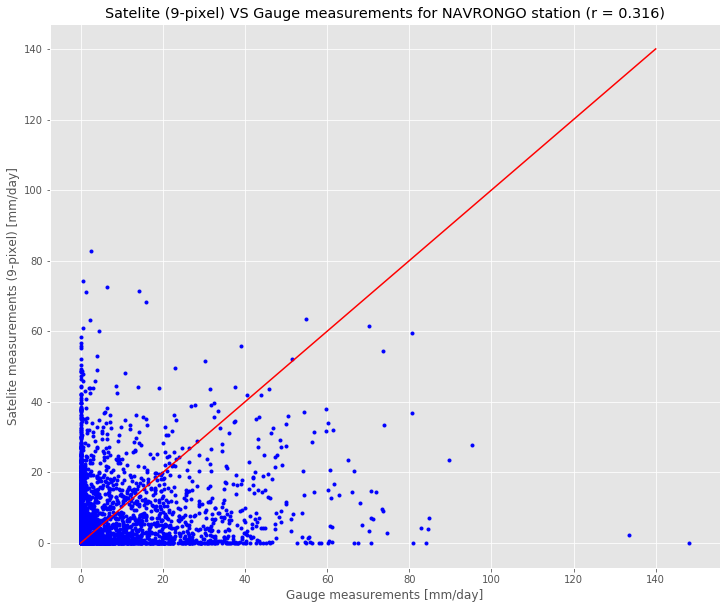

In [23]:
rho = NAVRONGOtrain['g[mm]'].corr(NAVRONGOtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(NAVRONGOtrain['g[mm]'], NAVRONGOtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 140, 2), np.linspace(0, 140, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9-pixel) VS Gauge measurements for NAVRONGO station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9-pixel) VS Gauge measurements for NAVRONGO station.png');

# 7. OUAHIGOUYA

In [24]:
OUAHIGOUYAtrain = OUAHIGOUYA.merge(OUAHIGOUYAsat9, how='left', left_on=OUAHIGOUYA.index, right_on=OUAHIGOUYAsat9.index)
OUAHIGOUYAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
OUAHIGOUYAtrain.set_index('Date', inplace=True)

OUAHIGOUYAtrain = OUAHIGOUYAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

OUAHIGOUYAtrain.to_csv("OrganisedData\TrainingData\OUAHIGOUYAtrain9pixelsMEAN.csv")

OUAHIGOUYAtrain

,g[mm],sat[mm]
Date,,
1980-01-01,0.0,0.0
1980-01-02,0.0,0.0
1980-01-03,0.0,0.0
1980-01-04,0.0,0.0
1980-01-05,0.0,0.0
...,...,...
2009-12-27,0.0,0.0
2009-12-28,0.0,0.0
2009-12-29,0.0,0.0


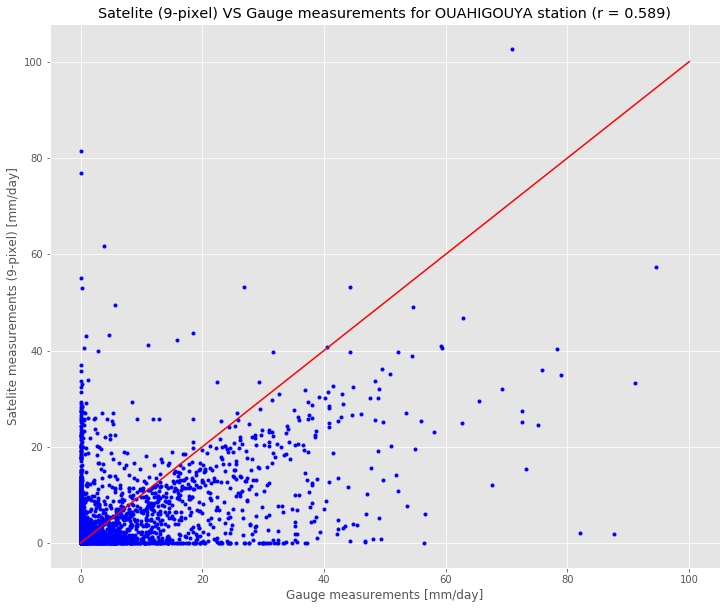

In [25]:
rho = OUAHIGOUYAtrain['g[mm]'].corr(OUAHIGOUYAtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(OUAHIGOUYAtrain['g[mm]'], OUAHIGOUYAtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9-pixel) VS Gauge measurements for OUAHIGOUYA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9-pixel) VS Gauge measurements for OUAHIGOUYA station.png');

# 8. TAMALE

In [26]:
TAMALEtrain = TAMALE.merge(TAMALEsat9, how='left', left_on=TAMALE.index, right_on=TAMALEsat9.index)
TAMALEtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
TAMALEtrain.set_index('Date', inplace=True)

TAMALEtrain = TAMALEtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

TAMALEtrain.to_csv("OrganisedData\TrainingData\TAMALEtrain9pixelsMEAN.csv")

TAMALEtrain

,g[mm],sat[mm]
Date,,
1980-01-01,0.0,0.0
1980-01-02,0.0,0.0
1980-01-03,0.0,0.0
1980-01-04,0.0,0.0
1980-01-05,0.0,0.0
...,...,...
2008-11-26,0.0,0.0
2008-11-27,0.0,0.0
2008-11-28,0.0,0.0


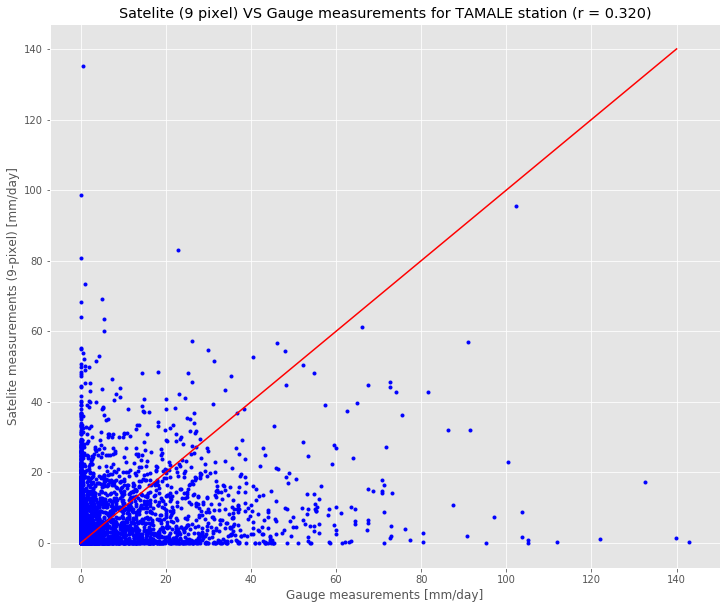

In [27]:
rho = TAMALEtrain['g[mm]'].corr(TAMALEtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(TAMALEtrain['g[mm]'], TAMALEtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 140, 2), np.linspace(0, 140, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for TAMALE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for TAMALE station.png');

# 9. WA

In [28]:
WAtrain = WA.merge(WAsat9, how='left', left_on=WA.index, right_on=WAsat9.index)
WAtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
WAtrain.set_index('Date', inplace=True)

WAtrain = WAtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

WAtrain.to_csv("OrganisedData\TrainingData\WAtrain9pixelsMEAN.csv")

WAtrain

,g[mm],sat[mm]
Date,,
1980-01-01,0.0,0.000000
1980-01-02,0.0,0.000000
1980-01-03,0.0,0.000000
1980-01-04,0.0,0.000000
1980-01-05,0.0,0.000000
...,...,...
2004-10-27,7.8,2.078889
2004-10-28,0.0,0.000000
2004-10-29,0.0,1.310000


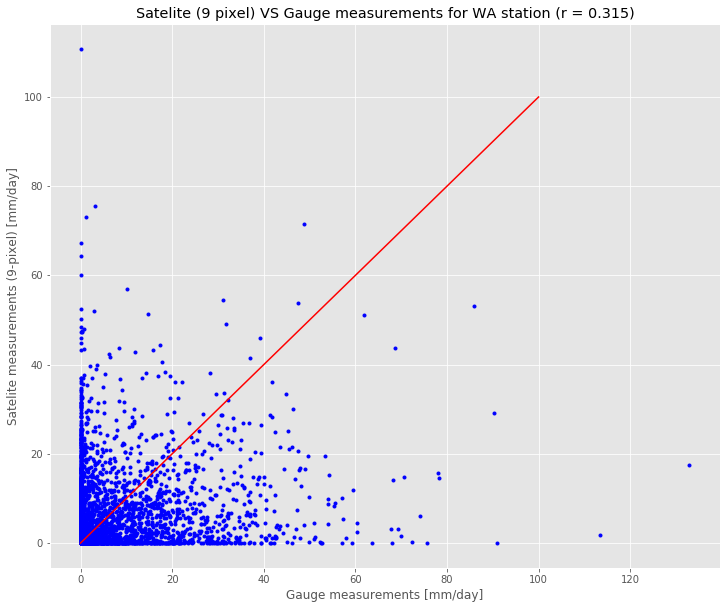

In [29]:
rho = WAtrain['g[mm]'].corr(WAtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(WAtrain['g[mm]'], WAtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for WA station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for WA station.png');

# 10. ZUARUNGU

In [30]:
ZUARUNGUtrain = ZUARUNGU.merge(ZUARUNGUsat9, how='left', left_on=ZUARUNGU.index, right_on=ZUARUNGUsat9.index)
ZUARUNGUtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
ZUARUNGUtrain.set_index('Date', inplace=True)

ZUARUNGUtrain = ZUARUNGUtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

ZUARUNGUtrain.to_csv("OrganisedData\TrainingData\ZUARUNGUtrain9pixelsMEAN.csv")

ZUARUNGUtrain

,g[mm],sat[mm]
Date,,
1980-01-01,0.0,0.000000
1980-01-02,0.0,0.000000
1980-01-03,0.0,0.000000
1980-01-04,0.0,0.000000
1980-01-05,0.0,0.000000
...,...,...
2004-10-27,0.0,0.000000
2004-10-28,0.0,0.000000
2004-10-29,0.0,0.000000


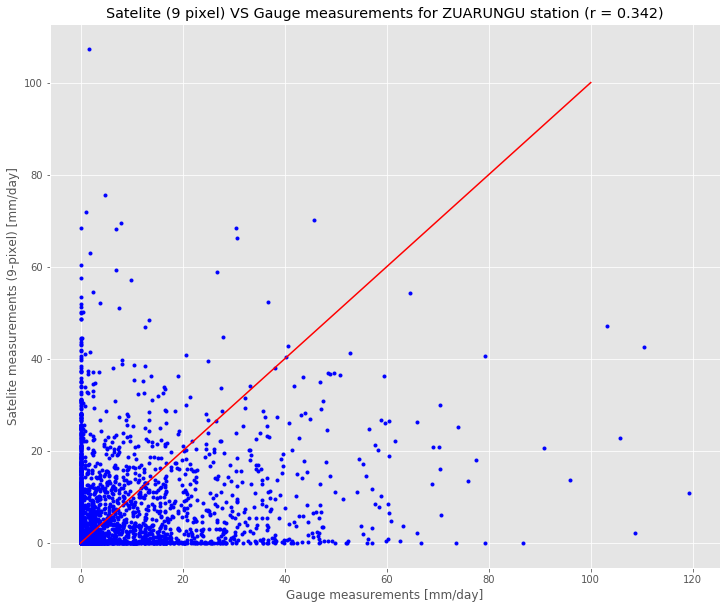

In [31]:
rho = ZUARUNGUtrain['g[mm]'].corr(ZUARUNGUtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(ZUARUNGUtrain['g[mm]'], ZUARUNGUtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for ZUARUNGU station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for ZUARUNGU station.png');

# 11. ANIABISI

In [32]:
ANIABISItrain = ANIABISI.merge(ANIABISIsat9, how='left', left_on=ANIABISI.index, right_on=ANIABISIsat9.index)
ANIABISItrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
ANIABISItrain.set_index('Date', inplace=True)

ANIABISItrain = ANIABISItrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

ANIABISItrain.to_csv("OrganisedData\TrainingData\ANIABISItrain9pixelsMEAN.csv")

ANIABISItrain

,g[mm],sat[mm]
Date,,
2014-06-04,0.00,1.466667
2014-06-05,1.25,2.562222
2014-06-06,9.05,9.321112
2014-06-07,0.00,0.000000
2014-06-08,0.00,0.000000
...,...,...
2015-12-27,0.00,0.000000
2015-12-28,0.00,0.000000
2015-12-29,0.00,0.000000


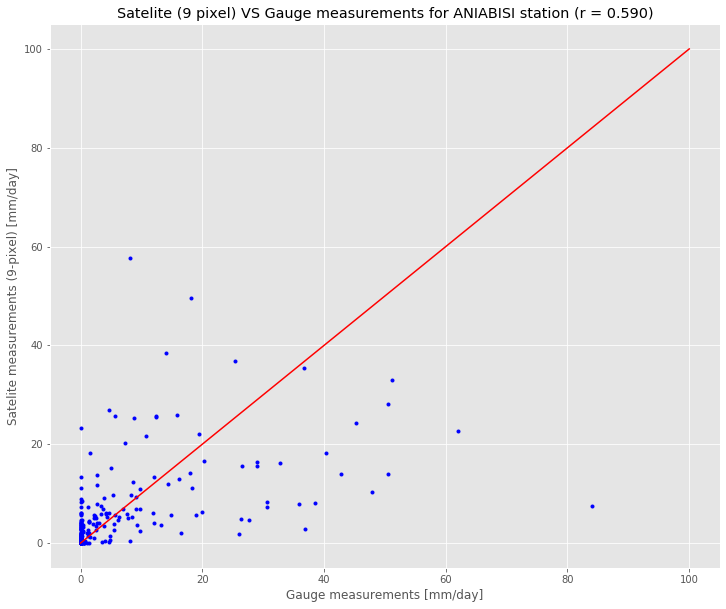

In [33]:
rho = ANIABISItrain['g[mm]'].corr(ANIABISItrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(ANIABISItrain['g[mm]'], ANIABISItrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for ANIABISI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for ANIABISI station.png');

# 12. POUDRI

In [34]:
POUDRItrain = POUDRI.merge(POUDRIsat9, how='left', left_on=POUDRI.index, right_on=POUDRIsat9.index)
POUDRItrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
POUDRItrain.set_index('Date', inplace=True)

POUDRItrain = POUDRItrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

POUDRItrain.to_csv("OrganisedData\TrainingData\POUDRItrain9pixelsMEAN.csv")

POUDRItrain

,g[mm],sat[mm]
Date,,
2013-06-25,0.90,3.480000
2013-06-26,0.00,0.718889
2013-06-27,31.55,13.438889
2013-06-28,0.00,3.962222
2013-06-29,12.45,19.175557
...,...,...
2015-12-27,0.00,0.000000
2015-12-28,0.05,0.000000
2015-12-29,0.00,0.000000


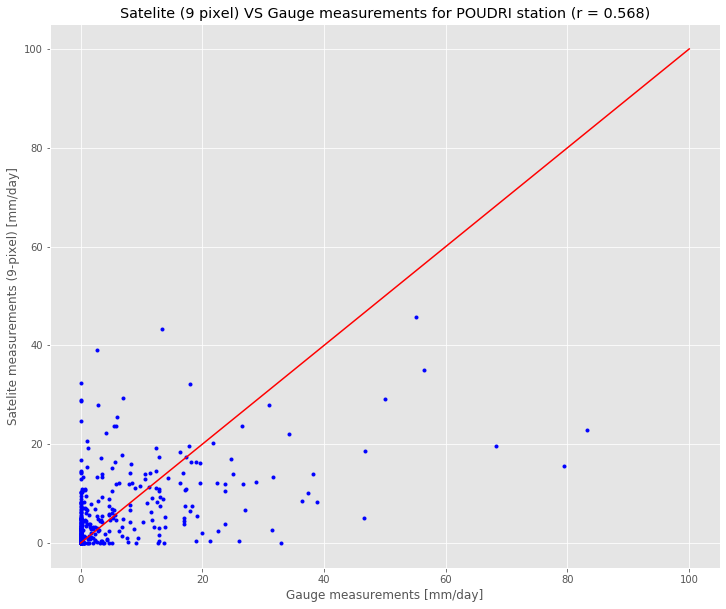

In [44]:
rho = POUDRItrain['g[mm]'].corr(POUDRItrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(POUDRItrain['g[mm]'], POUDRItrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for POUDRI station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for POUDRI station.png');

# 13. LARE

In [35]:
LAREtrain = LARE.merge(LAREsat9, how='left', left_on=LARE.index, right_on=LAREsat9.index)
LAREtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
LAREtrain.set_index('Date', inplace=True)

LAREtrain = LAREtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

LAREtrain.to_csv("OrganisedData\TrainingData\LAREtrain9pixelsMEAN.csv")

LAREtrain

,g[mm],sat[mm]
Date,,
2013-09-26,0.0,0.000000
2013-09-27,0.2,11.257778
2013-09-28,1.6,8.706667
2013-09-29,0.0,1.527778
2013-09-30,33.4,11.162222
...,...,...
2015-12-27,0.0,0.000000
2015-12-28,0.0,0.000000
2015-12-29,0.0,0.000000


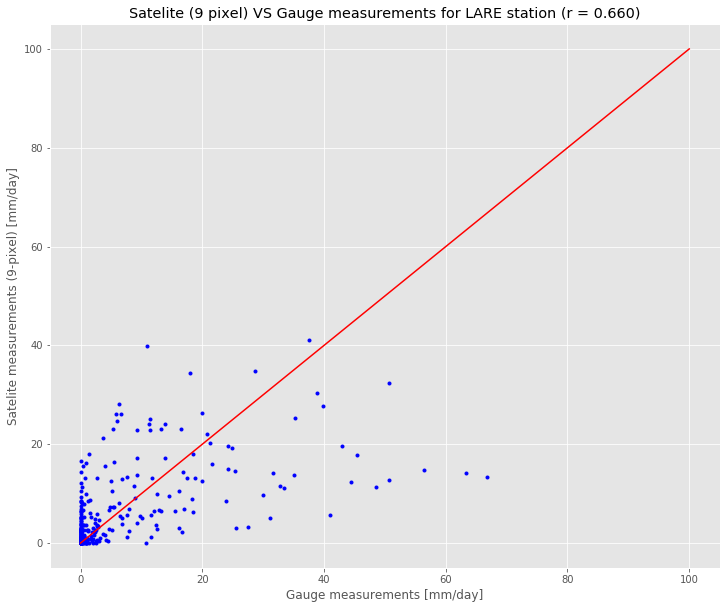

In [36]:
rho = LAREtrain['g[mm]'].corr(LAREtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(LAREtrain['g[mm]'], LAREtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for LARE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for LARE station.png');

# 14. YABOGANE

In [37]:
YABOGANEtrain = YABOGANE.merge(YABOGANEsat9, how='left', left_on=YABOGANE.index, right_on=YABOGANEsat9.index)
YABOGANEtrain.rename(columns = {'key_0': 'Date', 'R[mm]_x':'g[mm]', 'R[mm]_y':'sat[mm]'}, inplace=True)
YABOGANEtrain.set_index('Date', inplace=True)

YABOGANEtrain = YABOGANEtrain.dropna(axis=0, how='any')  # remove 2017 where satelite has no values

YABOGANEtrain.to_csv("OrganisedData\TrainingData\YABOGANEtrain9pixelsMEAN.csv")

YABOGANEtrain

,g[mm],sat[mm]
Date,,
2012-10-01,0.00,0.110000
2012-10-02,0.45,3.532222
2012-10-03,0.00,0.961111
2012-10-04,2.80,3.601111
2012-10-05,0.00,1.723333
...,...,...
2015-12-27,0.00,0.000000
2015-12-28,0.00,0.000000
2015-12-29,0.00,0.000000


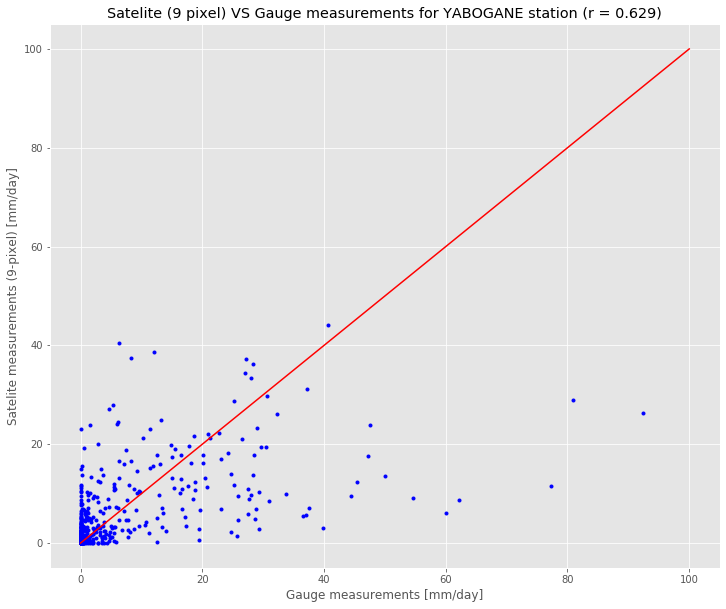

In [38]:
rho = YABOGANEtrain['g[mm]'].corr(YABOGANEtrain['sat[mm]'])

plt.figure(figsize=(12, 10))

plt.plot(YABOGANEtrain['g[mm]'], YABOGANEtrain['sat[mm]'], 'b.')
plt.plot(np.linspace(0, 100, 2), np.linspace(0, 100, 2), 'r')

plt.ylabel('Satelite measurements (9-pixel) [mm/day]')
plt.xlabel('Gauge measurements [mm/day]')

plt.title(f'Satelite (9 pixel) VS Gauge measurements for YABOGANE station (r = {rho:.3f})')

plt.savefig('DataFigures/Satelite (9 pixel) VS Gauge measurements for YABOGANE station.png');